In [1]:
import torch
import pickle

from encoding_utils import *
from flatten_lattice import *
from model_construct import *

2022-09-12 05:56:06.291541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 05:56:06.291562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
def submask_help(words):
    msk = []
    for i in range(len(words)-1):
        if "#" in words[i+1]:
            msk.append(0)
        else:
            msk.append(1)
    msk.append(1)
    return torch.tensor(msk)

def subword_mask_all ():
    msk = torch.ones_like(sents)
    for i in range(0, len(sents)):
        tmp = [tok.decode(s) for s in sents[i]]
        msk[i] = submask_help(tmp)
    return msk

def get_acc():
    # simplify prediction tensors
    ysimp = torch.clone(ylabels)
    psimp = torch.argmax(pred1, dim=2)
    # clean up labels
    sm = subword_mask_all()
    ysimp[sents==0] = 0
    ysimp[sents==102] = 0
    ysimp[sm==0] = 0
    ysimp[:, 0] = 0
    # apply cleanaup to x 
    psimp[ysimp==0] = 0
    # apply cleanaup to x 
    psimp[ysimp==0] = 0
    # compute accuracy
    acc = 1 - ((ysimp-psimp).count_nonzero())/ysimp.count_nonzero()
    return acc, ysimp, psimp

def get_tmap_acc(tmaps, sents):
    a, ysmp, p = get_acc()
    
    assert len(tmaps)==len(ysmp)
    cor = 0
    tot = 0
    inddistr = []
    for a in ysmp.nonzero():
        if int(p[a[0], a[1]]) in tmaps[a[0]][str(int(sents[a[0], a[1]]))]:
            #print(int(ysmp[a[0], a[1]]), " ",  tmaps[a[0]][str(int(sents[a[0], a[1]]))])
            cor+=1
        else:
            # print(int(ysmp[a[0], a[1]]))
            # print(int(p[a[0], a[1]]), " ",tmaps[a[0]][str(int(sents[a[0], a[1]]))] )
            inddistr.append(a[1])
        tot+=1
    print(cor/tot)
    print(cor)
    print(tot)
    return cor/tot, inddistr
            

def get_err_tensors():
    diff = ysimp-psimp
    diff = diff.abs().bool().int()
    errg = ysimp
    errp = psimp
    errg[diff==0] = 0
    errp[diff==0] = 0
    return errg, errp


def print_decoded(toks):
    nt = []
    for t in toks:
        if t==100 or t==101 or t==102 or t==0:
            continue
        nt.append(t)
    print(tok.decode(nt))
    return tok.decode(nt)
    
# 
def error_vis(ind):
    nt = print_decoded(sents[ind])
    p = [lablist[int(errp[ind][i])] for i in errp[ind].nonzero()]
    g = [lablist[int(errg[ind][i])] for i in errp[ind].nonzero()]
    s = [tok.decode(int(sents[ind][i])) for i in errp[ind].nonzero()]
    print("ERRORS : ")
    print("(predicted, gold, token)")
    print(list(zip(p, g, s)))
    return nt
    
def vis_model_pred(strinp):
    tokinps = tok(strinp, return_tensors='pt').input_ids.to(device)
    msk = torch.tril(torch.ones((len(tokinps[0]), len(tokinps[0]))))
    preds = bmodel(tokinps, attmasks=torch.stack([msk]).to(device))
    preds = torch.argmax(preds, dim=2)
    labs = [lablist[int(p)] for p in preds[0]]
    tinps = [tok.decode(int(t))for t in tokinps[0]]
    #print(list(zip(labs, tinps)))

In [ ]:
accuracy, ysimp, psimp = get_acc()


In [ ]:
len(ysimp.nonzero())

In [3]:
tok = fl.bert_tok

# loads in odata with keys: tmaps, masks, pgraphs
with open('torchsaved/outputv7.pkl', 'rb') as file:
    odata = pickle.load(file)
    
with open('./a3distrib/lab_vocab.json') as json_file:
    labels = json.load(json_file)
    
# load in other metadata
bmodel = load_model(labels)
sents, posids = create_inputs(odata['pgraphs'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GPU Mem Used =  534572544


In [4]:
ylabels = tmap_pos_goldlabels(odata['tmaps'], sents)   
lablist = [l for l in labels.keys()]
torch.cuda.empty_cache()

pg = odata['pgraphs']

missing token
missing token
missing token
missing token


In [19]:
sents, posids = create_inputs(odata['pgraphs'])
pred1 = bmodel(sents, fix_posids(posids), odata['masks'])
accuracy, ysimp, psimp = get_acc()

print("accuracy: ", accuracy)

errg, errp = get_err_tensors()

accuracy:  tensor(0.9288, device='cuda:1')


In [ ]:
ysimp[0]

In [ ]:
# can put any number between 0-100 and it will show an example and errors with the example
INP = 9
for i in range(0, 100):
    vis_model_pred(error_vis(i))

In [ ]:
len((ysimp-psimp).nonzero())

In [ ]:
len(ysimp.nonzero())

In [ ]:
#################### BEYOND THIS IS RANDOM SANITY CHECKING ########################################

In [21]:
ta, ind_distr = get_tmap_acc(odata['tmaps'], sents)

0.9654552521620834
19871
20582


In [22]:
import matplotlib.pyplot as plt

(array([15., 21., 14., 22., 28., 25., 15., 29., 24., 36., 19., 32., 29.,
        25., 33., 26., 19., 22., 23., 17., 22., 20., 18., 22., 18., 16.,
        18., 16.,  6.,  9., 12., 11.,  9.,  3.,  5.,  5.,  5.,  2.,  5.,
         0.,  1.,  1.,  0.,  3.,  2.,  2.,  1.,  3.,  0.,  2.]),
 array([ 16.  ,  24.72,  33.44,  42.16,  50.88,  59.6 ,  68.32,  77.04,
         85.76,  94.48, 103.2 , 111.92, 120.64, 129.36, 138.08, 146.8 ,
        155.52, 164.24, 172.96, 181.68, 190.4 , 199.12, 207.84, 216.56,
        225.28, 234.  , 242.72, 251.44, 260.16, 268.88, 277.6 , 286.32,
        295.04, 303.76, 312.48, 321.2 , 329.92, 338.64, 347.36, 356.08,
        364.8 , 373.52, 382.24, 390.96, 399.68, 408.4 , 417.12, 425.84,
        434.56, 443.28, 452.  ]),
 <BarContainer object of 50 artists>)

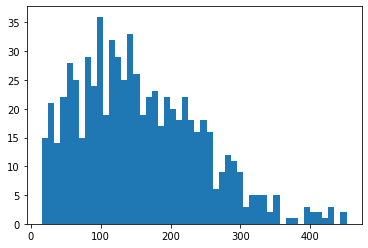

In [23]:
ind_distr = [int(i) for i in ind_distr]
plt.hist(ind_distr, bins=50)

In [ ]:
goldlist = []
predlist = []
toklist = []
for e in errg.nonzero():
    goldlist.append(lablist[int(errg[e[0], e[1]])])
    predlist.append(lablist[int(errp[e[0], e[1]])])
    toklist.append(tok.decode(int(sents[e[0], e[1]])))
    
zipped = list(zip(goldlist, predlist, toklist))
zipcln = []
cnt = 0
for z in zipped:
    if z[1]==z[2]:
        cnt+=1
        continue
    zipcln.append(z)
    

In [ ]:
# sanity check masking 
sents.shape

In [ ]:
odata['masks'].shape

In [ ]:
def print_mask_leadup(ind):
    msk = odata['masks'][ind]
    smat = torch.zeros_like(msk)
    smat[:, :] = sents[ind]
    assert msk.shape == smat.shape
    return smat, msk

In [ ]:
sm, m = print_mask_leadup(0)

In [ ]:
sm[m==0]=0

In [ ]:
inps = tok.batch_decode(sm.int())

In [ ]:
inps = [txt.replace(" [PAD]", "") for txt in inps]

In [ ]:
posids[0]

In [ ]:
a = torch.zeros(5, 5)
a[:3, :3] = torch.ones(3, 3)

In [ ]:
torch.tril(a)